# Part 4: Fraud

In [1]:
%run "../scripts/ETL.py"

## [1] Check fraud datasets

#### Consumer fraud data
The consumer fraud data shows the list of transactions with the probability that the entire batch of transaction done by that consumer on that day could be considered fraudulent.

In [2]:
print(fraud_consumer.count())
fraud_consumer.limit(5)

34864


user_id,order_datetime,fraud_probability
6228,2021-12-19,97.6298077657765
21419,2021-12-10,99.24738020302328
5606,2021-10-17,84.05825045251777
3101,2021-04-17,91.42192091901347
22239,2021-10-19,94.70342477508035


#### Merchant fraud data
The merchant fraud data shows the probability that the entire batch of transaction done with that merchant on that day could be considered fraudulent.
This could happen when merchants are targeted by scalper bots or other attacks during sales (i.e. the consumers committed fraud for merchants whether on purpose or because their details were stolen).

In [3]:
print(fraud_merchants.count())
fraud_merchants.limit(5)

114


merchant_abn,order_datetime,fraud_probability
19492220327,2021-11-28,44.403658647495355
31334588839,2021-10-02,42.75530083865367
19492220327,2021-12-22,38.867790051131095
82999039227,2021-12-19,94.1347004808891
90918180829,2021-09-02,43.32551731714902


#### Dataset to join fraud data

In [4]:
final_join.limit(5)

merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,postcode,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Ashley Harris,84610 Amy Harbors,QLD,4184,Female,12516851436,285.1622236961745,eda709b9-dcd3-449...,2022-02-08,14971,1144223
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,William Ali,3166 Annette Port...,NSW,1022,Male,12516851436,75.4722398570927,92f8ad85-c6d8-409...,2022-08-13,20642,1153786
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Anna Strickland,906 Pham Village ...,SA,5250,Female,12516851436,47.830718899387165,ab3d0252-d05f-44f...,2022-04-10,20311,1223293
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Michael Bishop,98598 Murray Trai...,QLD,4580,Male,12516851436,259.43552349322687,0aad2674-03ee-4d8...,2022-03-25,22971,443950
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Mary Diaz,4111 Jason Ville,SA,5038,Female,12516851436,62.60867338695297,dfb805b6-1aad-4ea...,2022-08-04,10575,626154


## [2] Join Fraud dataset to the processed transaction dataset

- join consumer fraud to final join
- create a version of final join with removed transactions from fraud
- aggregate final join from transaction to merchant level
- add fraud merchant as a feature to aggregated final join
- treat fraud as response and try to create model to give other merchants a fraud score

#### (1) Add consumer fraud data

In [7]:
# adding consumer fraud data
fj_with_fraud = final_join.alias("a").join(fraud_consumer.alias("b"), (final_join.user_id == fraud_consumer.user_id) \
                               & (final_join.order_datetime == fraud_consumer.order_datetime), "left_outer") \
                                .select("a.*","b.fraud_probability")

# rename fraud probability for consumer fraud data
fj_with_fraud = fj_with_fraud.withColumnRenamed('fraud_probability', 'fraud_probability_consumer')


merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,postcode,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,fraud_probability
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Ashley Harris,84610 Amy Harbors,QLD,4184,Female,12516851436,285.1622236961745,eda709b9-dcd3-449...,2022-02-08,14971,1144223,null
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,William Ali,3166 Annette Port...,NSW,1022,Male,12516851436,75.4722398570927,92f8ad85-c6d8-409...,2022-08-13,20642,1153786,null
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Anna Strickland,906 Pham Village ...,SA,5250,Female,12516851436,47.830718899387165,ab3d0252-d05f-44f...,2022-04-10,20311,1223293,null
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Michael Bishop,98598 Murray Trai...,QLD,4580,Male,12516851436,259.43552349322687,0aad2674-03ee-4d8...,2022-03-25,22971,443950,null
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Mary Diaz,4111 Jason Ville,SA,5038,Female,12516851436,62.60867338695297,dfb805b6-1aad-4ea...,2022-08-04,10575,626154,null


In [ ]:
#fj_with_fraud.limit(5)

In [15]:
# save for later use
#fj_with_fraud.write.parquet('../data/curated/fj_consumerFraud.parquet')

#### (2) Add merchant fraud data

In [17]:
# adding merchant fraud data
fj_with_fraud = fj_with_fraud.alias("a").join(fraud_merchants.alias("b"), (fj_with_fraud.merchant_abn == fraud_merchants.merchant_abn) \
                               & (fj_with_fraud.order_datetime == fraud_merchants.order_datetime), "left_outer") \
                                .select("a.*","b.fraud_probability")
    
# rename fraud probability for merchant fraud data
fj_with_fraud = fj_with_fraud.withColumnRenamed('fraud_probability', 'fraud_probability_merchant')


In [18]:
#fj_with_fraud.limit(5)

merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,postcode,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,fraud_probability_consumer,fraud_probability_merchant
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Ashley Harris,84610 Amy Harbors,QLD,4184,Female,12516851436,285.1622236961745,eda709b9-dcd3-449...,2022-02-08,14971,1144223,null,null
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,William Ali,3166 Annette Port...,NSW,1022,Male,12516851436,75.4722398570927,92f8ad85-c6d8-409...,2022-08-13,20642,1153786,null,null
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Anna Strickland,906 Pham Village ...,SA,5250,Female,12516851436,47.830718899387165,ab3d0252-d05f-44f...,2022-04-10,20311,1223293,null,null
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Michael Bishop,98598 Murray Trai...,QLD,4580,Male,12516851436,259.43552349322687,0aad2674-03ee-4d8...,2022-03-25,22971,443950,null,null
Mollis Corp.,12516851436,"watch, clock, and...",6.71,a,Mary Diaz,4111 Jason Ville,SA,5038,Female,12516851436,62.60867338695297,dfb805b6-1aad-4ea...,2022-08-04,10575,626154,null,null


In [19]:
# save for later use
#fj_with_fraud.write.parquet('../data/curated/fj_consumer_merchant_fraud.parquet')

#### (3) Remove instance with Null fraud probability

In [20]:
# dataset with both merchant and consumer fraud probability i.e. remove null probabilities
fj_fraud_prob = fj_with_fraud.filter(col("fraud_probability_consumer").isNotNull() & col("fraud_probability_merchant").isNotNull())

In [45]:
# save for later use
#fj_fraud_prob.write.parquet('../data/curated/consumer_merchant_fraud_notNull.parquet')

In [21]:
#fj_fraud_prob.limit(5)

merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,postcode,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,fraud_probability_consumer,fraud_probability_merchant
Arcu Morbi Institute,39649557865,artist supply and...,1.47,c,Michael Henderson MD,93987 Daniel Vill...,WA,6427,Male,39649557865,1523.9317579642068,ebf92d8d-b272-4b8...,2021-11-26,161,1141213,8.57568823160988,28.690204286050616
Ligula Elit Preti...,83199298021,antique shops - s...,4.82,b,Ryan Wright,6031 Patrick Lane...,WA,6350,Male,83199298021,44471.999391282814,4463230f-9745-4a4...,2022-02-27,3513,1454256,75.16981192247916,26.025158824861773
Ligula Elit Preti...,83199298021,antique shops - s...,4.82,b,Ryan Wright,6031 Patrick Lane...,WA,6350,Male,83199298021,44471.999391282814,4463230f-9745-4a4...,2022-02-27,3513,1454256,75.16981192247916,26.025158824861773
Mauris Non Institute,21439773999,"cable, satellite,...",6.1,a,Michael Quinn,32754 Herbert Radial,NSW,2260,Male,21439773999,99.68921242913112,2d9c7367-23f5-472...,2021-11-26,3435,1160567,36.82560105712125,28.504479048104585
Lacus Aliquam Cor...,31334588839,antique shops - s...,4.22,b,Dominique Adams,30228 Alexander R...,WA,6107,Undisclosed,31334588839,3772.1317360358003,d9d38a94-cc9b-481...,2021-11-29,13550,1308424,14.274656540979628,35.386213297375505


In [28]:
fj_fraud_prob.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- categories: string (nullable = true)
 |-- take_rate: double (nullable = true)
 |-- revenue_levels: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- trans_merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: string (nullable = true)
 |-- fraud_probability_merchant: string (nullable = true)



#### Check number of instances for each dataset
The dataset with both merchant and consumer fraud probability has 389 instances which might be small for the analysis.

The dataset with merchant fraud probability has 4028 and one with consumer fraud probability has 80560 instances.

In [47]:
fj_fraud_prob.count(), len(fj_fraud_prob.columns)

(389, 18)

In [38]:
# consumer fraud not null
fj_with_fraud.filter(col("fraud_probability_consumer").isNotNull()).count()

80560

In [40]:
# merchant fraud not null
fj_with_fraud.filter(col("fraud_probability_merchant").isNotNull()).count()

4028

## [3] Clustering model to detect fraud

In [46]:
fj_with_fraud = pd.read_parquet('../data/curated/fj_consumer_merchant_fraud.parquet')

,merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,postcode,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,fraud_probability_consumer,fraud_probability_merchant
0,Mollis Corp.,1.251685e+10,"watch, clock, and jewelry repair shops",6.71,a,Ashley Harris,84610 Amy Harbors,QLD,4184,Female,12516851436,285.162224,eda709b9-dcd3-4492-8cdc-968cef5e89d9,2022-02-08,14971,1144223,None,None
1,Mollis Corp.,1.251685e+10,"watch, clock, and jewelry repair shops",6.71,a,William Ali,3166 Annette Ports Suite 234,NSW,1022,Male,12516851436,75.472240,92f8ad85-c6d8-409a-b82d-d55d2446eb54,2022-08-13,20642,1153786,None,None
2,Mollis Corp.,1.251685e+10,"watch, clock, and jewelry repair shops",6.71,a,Anna Strickland,906 Pham Village Suite 039,SA,5250,Female,12516851436,47.830719,ab3d0252-d05f-44f2-a184-3095ad27a300,2022-04-10,20311,1223293,None,None
3,Mollis Corp.,1.251685e+10,"watch, clock, and jewelry repair shops",6.71,a,Michael Bishop,98598 Murray Trail Suite 603,QLD,4580,Male,12516851436,259.435523,0aad2674-03ee-4d8e-8ceb-99a05d6b8698,2022-03-25,22971,443950,None,None
4,Mollis Corp.,1.251685e+10,"watch, clock, and jewelry repair shops",6.71,a,Mary Diaz,4111 Jason Ville,SA,5038,Female,12516851436,62.608673,dfb805b6-1aad-4ea1-a229-a695682eb2d6,2022-08-04,10575,626154,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14195712,Nunc Risus LLP,9.900929e+10,"computer programming , data processing, and in...",3.15,b,Robert Luna,72037 Summers Underpass Apt. 530,SA,5034,Male,99009287608,251.696240,7ed92383-3f37-483d-a601-1ed608139749,2021-12-10,15220,493495,None,None
14195713,Nunc Risus LLP,9.900929e+10,"computer programming , data processing, and in...",3.15,b,Michael Wong,4621 Smith Summit,VIC,3965,Male,99009287608,484.389368,816d23f0-c53c-4d8e-953a-fe66fc092643,2022-05-05,18056,777734,None,None
14195714,Nunc Risus LLP,9.900929e+10,"computer programming , data processing, and in...",3.15,b,Victoria Davis,65123 Gabrielle Forges,WA,6028,Female,99009287608,128.620448,3811d8fa-113a-48a7-b1c0-f41a51098e47,2021-06-30,16004,1247635,None,None
14195715,Nunc Risus LLP,9.900929e+10,"computer programming , data processing, and in...",3.15,b,Kimberly Morrison,27437 Davila Terrace,QLD,4497,Female,99009287608,214.903545,5379f32a-afeb-4415-8045-465d562b72fd,2021-06-09,21322,830647,None,None


In [ ]:
# clustering based on the number of purchase per day, => requires aggregation
# amount per purchase (usually make small transactions but big one transaction is made => fraud?), 
# fraud probability

In [ ]:
########### Change: Run the script once, and save data dataset, use it from the saved data

In [3]:
#import pandas as pd
fj_fraud_prob = pd.read_parquet('../data/curated/consumer_merchant_fraud_notNull.parquet')

In [4]:
fj_fraud_prob.head()

,merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,postcode,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,fraud_probability_consumer,fraud_probability_merchant
0,Arcu Morbi Institute,39649557865,artist supply and craft shops,1.47,c,Michael Henderson MD,93987 Daniel Villages Suite 247,WA,6427,Male,39649557865,1523.931758,ebf92d8d-b272-4b87-81cd-674c3b2d5cb2,2021-11-26,161,1141213,8.57568823160988,28.690204286050616
1,Ligula Elit Pretium Foundation,83199298021,"antique shops - sales, repairs, and restoratio...",4.82,b,Ryan Wright,6031 Patrick Lane Apt. 975,WA,6350,Male,83199298021,44471.999391,4463230f-9745-4a4a-9f5a-2609f8d549b2,2022-02-27,3513,1454256,75.16981192247916,26.025158824861773
2,Ligula Elit Pretium Foundation,83199298021,"antique shops - sales, repairs, and restoratio...",4.82,b,Ryan Wright,6031 Patrick Lane Apt. 975,WA,6350,Male,83199298021,44471.999391,4463230f-9745-4a4a-9f5a-2609f8d549b2,2022-02-27,3513,1454256,75.16981192247916,26.025158824861773
3,Mauris Non Institute,21439773999,"cable, satellite, and other pay television and...",6.10,a,Michael Quinn,32754 Herbert Radial,NSW,2260,Male,21439773999,99.689212,2d9c7367-23f5-4724-bd64-db65ba64b560,2021-11-26,3435,1160567,36.82560105712125,28.504479048104585
4,Lacus Aliquam Corporation,31334588839,"antique shops - sales, repairs, and restorati...",4.22,b,Dominique Adams,30228 Alexander River,WA,6107,Undisclosed,31334588839,3772.131736,d9d38a94-cc9b-4810-8938-23d8e84c0de4,2021-11-29,13550,1308424,14.274656540979628,35.386213297375505


In [4]:
import numpy as np
# apply double type to fraud probability
# move this code to earlier in the data processing step
fj_fraud_prob.fraud_probability_consumer = fj_fraud_prob.fraud_probability_consumer.astype(np.double)
fj_fraud_prob.fraud_probability_merchant = fj_fraud_prob.fraud_probability_merchant.astype(np.double)

In [23]:
fj_fraud_prob.dtypes

merchant_name                  object
merchant_abn                    int64
categories                     object
take_rate                     float64
revenue_levels                 object
name                           object
address                        object
state                          object
postcode                       object
gender                         object
trans_merchant_abn              int64
dollar_value                  float64
order_id                       object
order_datetime                 object
user_id                         int64
consumer_id                     int64
fraud_probability_consumer    float64
fraud_probability_merchant    float64
dtype: object

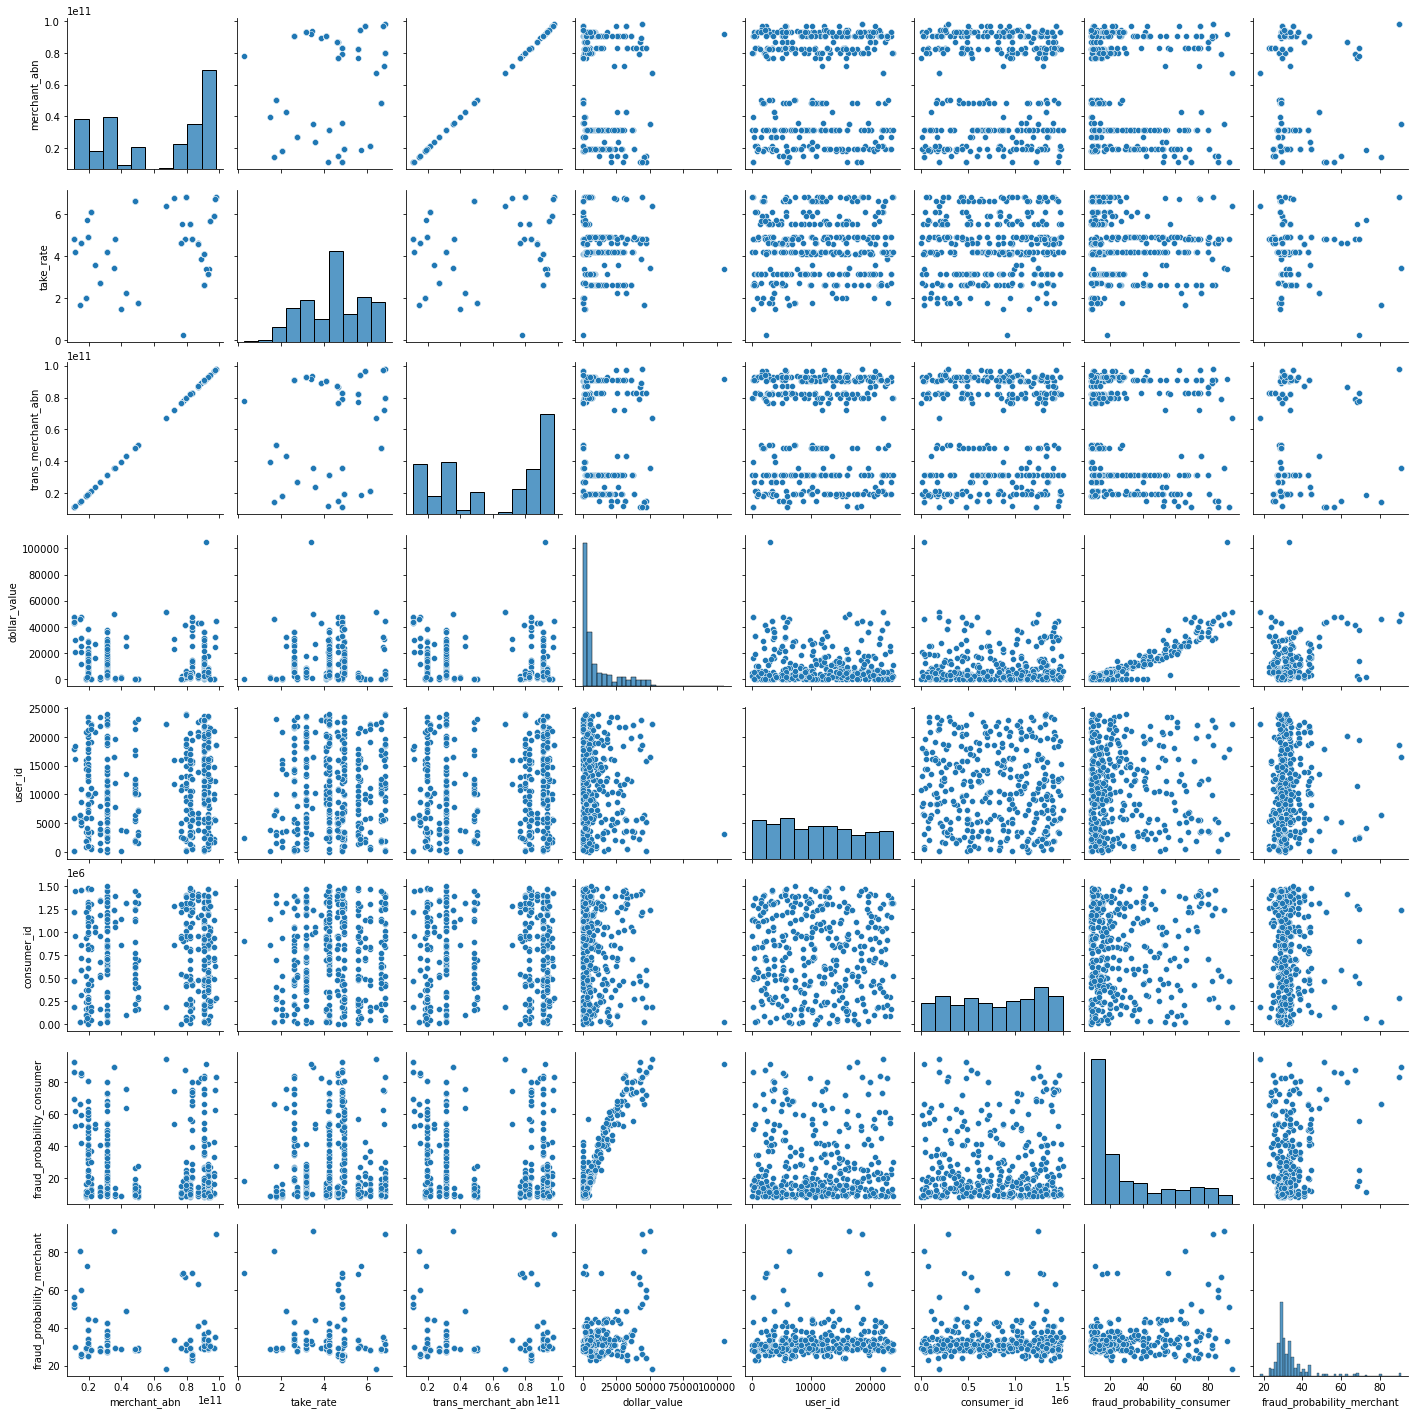

In [24]:
# see the relations, modify & select which attributes to visualise
import seaborn as sns
sns.pairplot(fj_fraud_prob.drop(columns=["merchant_name", "categories", "name", "address", "order_id"]))

C:\Users\taiya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_probability_consumer', ylabel='fraud_probability_merchant'>

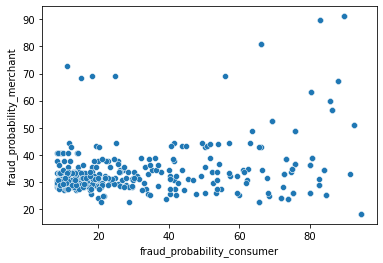

In [25]:
sns.scatterplot(fj_fraud_prob.fraud_probability_consumer, fj_fraud_prob.fraud_probability_merchant)

In [54]:
pip install threadpoolctl --upgrade

  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.1.0
    Uninstalling threadpoolctl-2.1.0:
      Successfully uninstalled threadpoolctl-2.1.0
Note: you may need to restart the kernel to use updated packages.


In [8]:
# make a simple clustering model as a first step
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
# might be good to scale before

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = fj_fraud_prob.loc[:,["fraud_probability_consumer", "dollar_value"]].to_numpy()


for k in K:
    
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
    



C:\Users\taiya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\taiya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\taiya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\taiya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

1 : 11037.291475924461
2 : 4724.697324103089
3 : 3304.4922647785706
4 : 3088.493555840279
5 : 2392.313803467872
6 : 1866.2526206009513
7 : 1656.5103048025346
8 : 1318.4009934005244
9 : 1103.685113377089


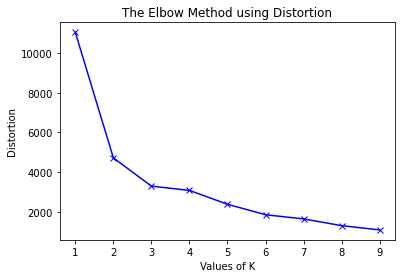

In [9]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

1 : 80872238442.8498
2 : 18161310144.807835
3 : 10397705794.902012
4 : 6185011275.234062
5 : 3418030256.4410906
6 : 2186456009.357738
7 : 1526681761.6947727
8 : 1139870077.0131593
9 : 872588545.6601436


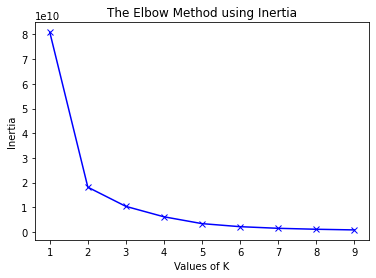

In [10]:
for key, val in mapping2.items():
    print(f'{key} : {val}')
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [16]:
# Building and fitting the model
X = fj_fraud_prob.loc[:,["fraud_probability_consumer", "dollar_value"]]
kmeanModel3 = KMeans(n_clusters=3)
label = kmeanModel3.fit_predict(X)
X["label"] = label

C:\Users\taiya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


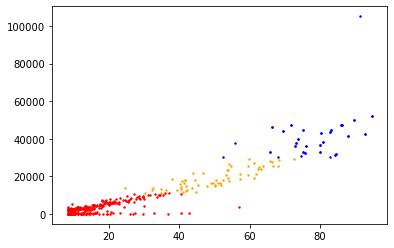

In [29]:
plt.scatter(X[label == 0].iloc[:,0], X[label == 0].iloc[:,1], color='red', s=2)
plt.scatter(X[label == 1].iloc[:,0], X[label == 1].iloc[:,1], color='blue', s=2)
plt.scatter(X[label == 2].iloc[:,0], X[label == 2].iloc[:,1], color='orange', s=2)
plt.show()

In [39]:
# Building and fitting the model
X = fj_fraud_prob.loc[:,["fraud_probability_consumer", "dollar_value"]]
kmeanModel5 = KMeans(n_clusters=5)
label5 = kmeanModel5.fit_predict(X)
X["label"] = label5

C:\Users\taiya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


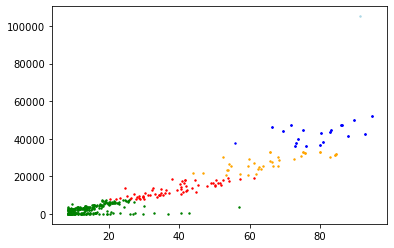

In [44]:
plt.scatter(X[label5 == 0].iloc[:,0], X[label5 == 0].iloc[:,1], color='red', s=2)
plt.scatter(X[label5 == 2].iloc[:,0], X[label5 == 2].iloc[:,1], color='orange', s=2)
plt.scatter(X[label5 == 3].iloc[:,0], X[label5 == 3].iloc[:,1], color='lightblue', s=2)
plt.scatter(X[label5 == 4].iloc[:,0], X[label5 == 4].iloc[:,1], color='green', s=2)
plt.show()

In [ ]:
# from the previous file

In [22]:
fj_rem_fraud = fj_with_fraud.filter("fraud_probability is NULL")
fj_rem_fraud.count()

14115157

In [16]:
user_details.count()

499999

In [23]:
final_join.count()

14195505

In [24]:
tbl_merchants.limit(5)

merchant_name,merchant_abn,categories,take_rate,revenue_levels
Felis Limited,10023283211,"furniture, home f...",0.18,e
Arcu Ac Orci Corp...,10142254217,"cable, satellite,...",4.22,b
Nunc Sed Company,10165489824,"jewelry, watch, c...",4.4,b
Ultricies Digniss...,10187291046,"wAtch, clock, and...",3.29,b
Enim Condimentum PC,10192359162,music shops - mus...,6.33,a
